In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pygam import LinearGAM, l, s
from statsmodels.tsa import seasonal

np.int = int
import scipy.sparse

scipy.sparse.csr_matrix.A = property(lambda self: self.toarray())

<Axes: xlabel='time'>

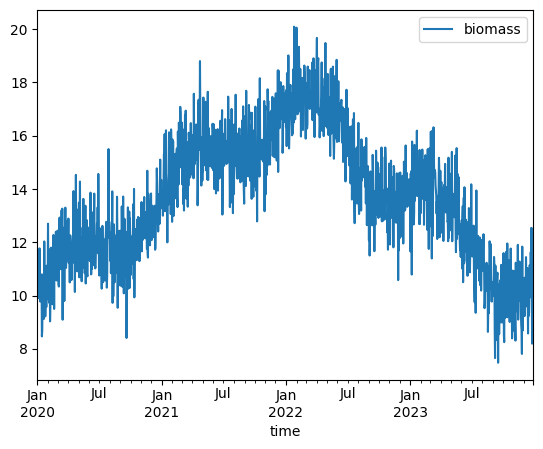

In [2]:
# Création d'une série temporelle sinusoïdale bruitée
np.random.seed(42)
n_points = 365 * 4
time = pd.date_range(start="2020-01-01", periods=n_points, freq="D")
season_in = np.sin(2 * np.pi * time.dayofyear / 365)
trend_in = np.ones_like(time, dtype=int) / 100
trend_in[-int(n_points / 2) :] = -1 / 100
trend_in = np.cumsum(trend_in) + 10  # tendance linéaire
noise = np.random.normal(0, 1, n_points)
biomass = season_in + noise + trend_in

data = pd.DataFrame({"time": time, "biomass": biomass}).set_index("time")

data.plot()

# Seasonal_decompose

---


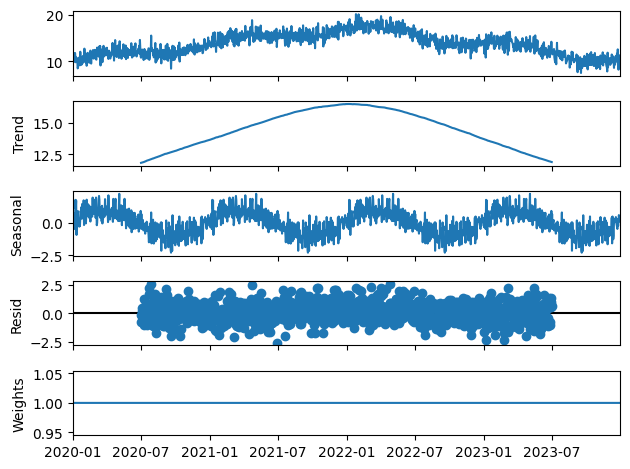

In [3]:
result_seasonal_decompose = seasonal.seasonal_decompose(data, model="additive", period=365)
_ = result_seasonal_decompose.plot(weights=True)

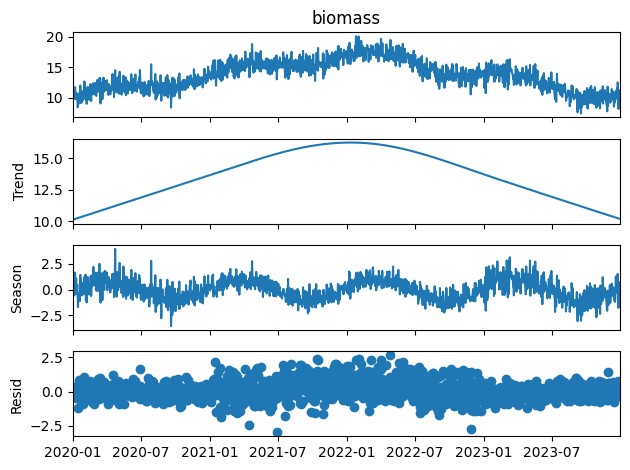

In [4]:
result_stl = seasonal.STL(data["biomass"], period=365).fit()
_ = result_stl.plot()

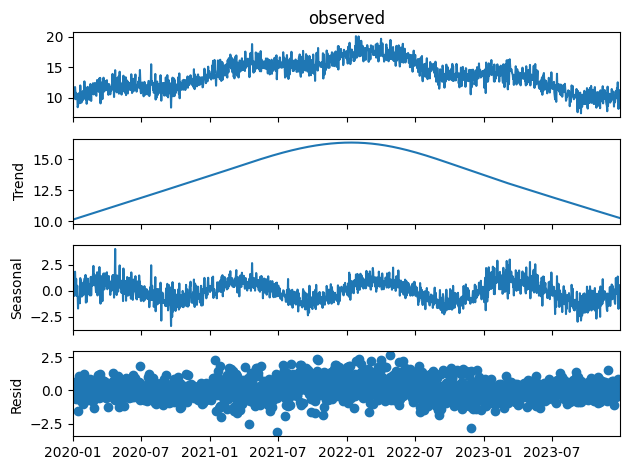

In [5]:
# result_mstl = seasonal.MSTL(data["biomass"], periods=(int(365.25 / 4), int(365.25))).fit()
result_mstl = seasonal.MSTL(data["biomass"], periods=(int(365.25),)).fit()
_ = result_mstl.plot()

# MANUEL

---


In [6]:
data_gam = data.reset_index().copy()
data_gam["time"] = pd.to_datetime(data_gam["time"])
data_gam["day_since_start"] = np.cumsum(np.ones_like(data_gam["time"], dtype=int))
data_gam["sin_doy"] = np.sin(2 * np.pi * data_gam["day_since_start"] / 365.25)
data_gam["cos_doy"] = np.cos(2 * np.pi * data_gam["day_since_start"] / 365.25)
data_gam

,time,biomass,day_since_start,sin_doy,cos_doy
0,2020-01-01,10.523928,1,0.017202,0.999852
1,2020-01-02,9.916157,2,0.034398,0.999408
2,2020-01-03,10.729308,3,0.051584,0.998669
3,2020-01-04,11.631832,4,0.068755,0.997634
4,2020-01-05,9.901811,5,0.085906,0.996303
...,...,...,...,...,...
1455,2023-12-26,8.193272,1456,-0.085906,0.996303
1456,2023-12-27,10.714539,1457,-0.068755,0.997634
1457,2023-12-28,10.349539,1458,-0.051584,0.998669
1458,2023-12-29,11.265331,1459,-0.034398,0.999408


In [ ]:
for degree in [10, 20, 40, 80]:
    variable = "biomass"
    X = data_gam[["day_since_start", "sin_doy", "cos_doy"]].to_numpy()
    y = data_gam[variable].to_numpy()
    gam = LinearGAM(s(0, n_splines=degree) + l(1) + l(2), fit_intercept=False).fit(X, y)
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)
    residuals = y - trend - season

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 6))
    plt.suptitle(f"Degree {degree}")
    ax1.plot(season, label="GAM")
    ax1.plot(season_in, label="Real")
    ax1.plot(result_stl.seasonal.to_numpy(), label="STL trend", alpha=0.2)
    ax2.plot(trend, label="GAM")
    ax2.plot(trend_in, label="Real")
    ax2.plot(result_stl.trend.to_numpy(), label="STL trend")
    ax3.plot(residuals)
    ax1.legend()
    ax2.legend()
    plt.show()

# Real data

---


<Axes: xlabel='time'>

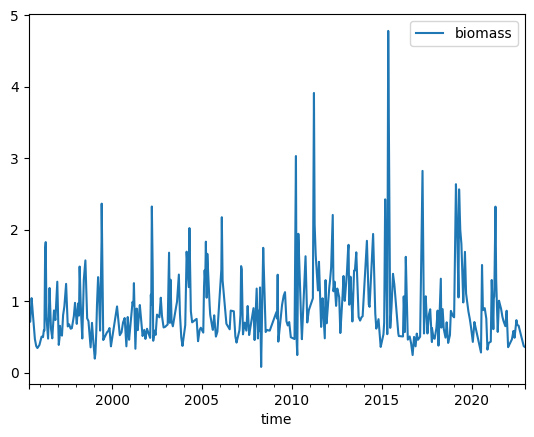

In [8]:
import xarray as xr

data = xr.open_dataset(
    "/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/notebooks/1_data_processing/1_1_Forcing/data/1_products/Bats_obs.zarr",
    engine="zarr",
)
data = (
    data.day.mean(["latitude", "longitude", "layer"])
    .to_dataframe()
    .reset_index()
    .dropna()
    .set_index("time")
    .resample("D")
    .mean()
    .interpolate("linear")
    .rename(columns={"day": "biomass"})
)
data.plot()

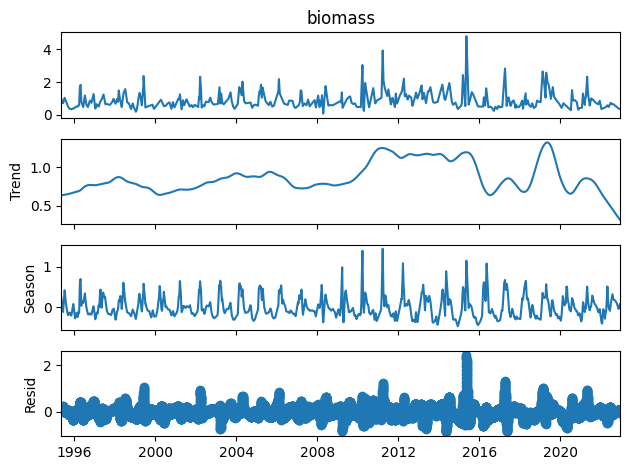

In [9]:
result_stl = seasonal.STL(data["biomass"], period=int(365.25)).fit()
_ = result_stl.plot()

In [22]:
result_stl


In [10]:
pd.DataFrame([result_stl.trend, result_stl.seasonal, result_stl.resid]).T

,trend,season,resid
time,,,
1995-05-11,0.639729,0.243983,0.080287
1995-05-12,0.639790,0.231563,0.085011
1995-05-13,0.639851,0.219143,0.089734
1995-05-14,0.639913,0.206723,0.094455
1995-05-15,0.639976,0.194303,0.099176
...,...,...,...
2022-12-09,0.323312,0.058169,-0.017796
2022-12-10,0.322313,0.063212,-0.022263
2022-12-11,0.321316,0.068306,-0.026779


In [11]:
pd.DataFrame([result_mstl.trend, result_mstl.resid]).T.merge(result_mstl.seasonal, on="time")


,trend,resid,seasonal
time,,,
2020-01-01,10.146997,0.241906,0.135025
2020-01-02,10.156560,-0.071738,-0.168664
2020-01-03,10.166123,-0.210124,0.773310
2020-01-04,10.175685,0.632814,0.823332
2020-01-05,10.185248,0.212772,-0.496208
...,...,...,...
2023-12-26,10.311368,-0.374656,-1.743439
2023-12-27,10.302226,0.476433,-0.064120
2023-12-28,10.293086,-0.227880,0.284333


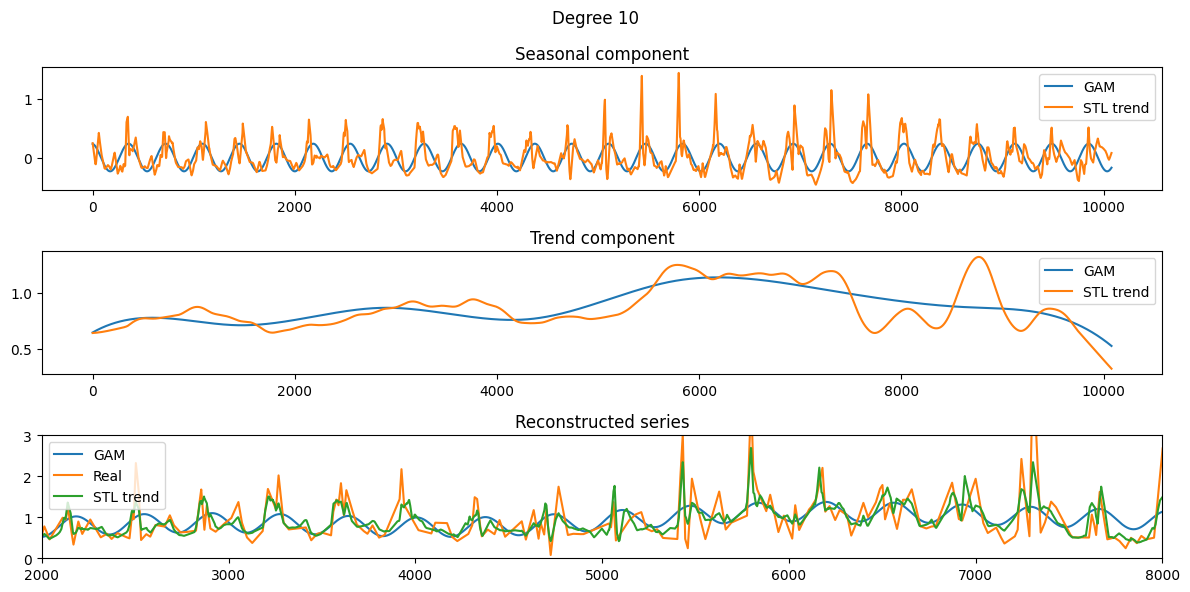

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


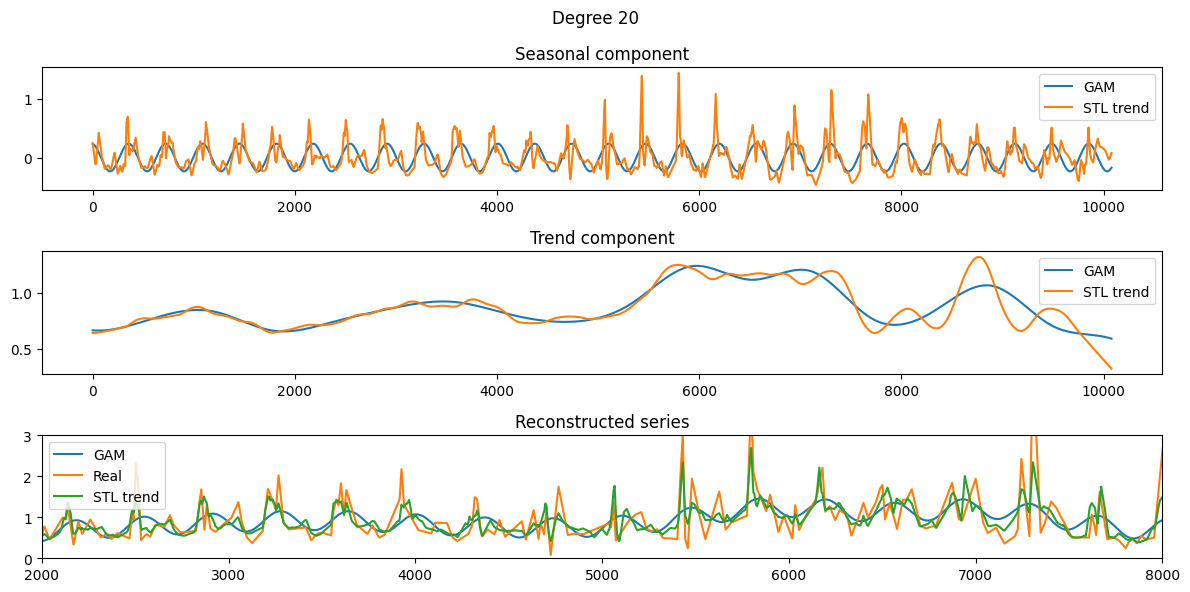

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


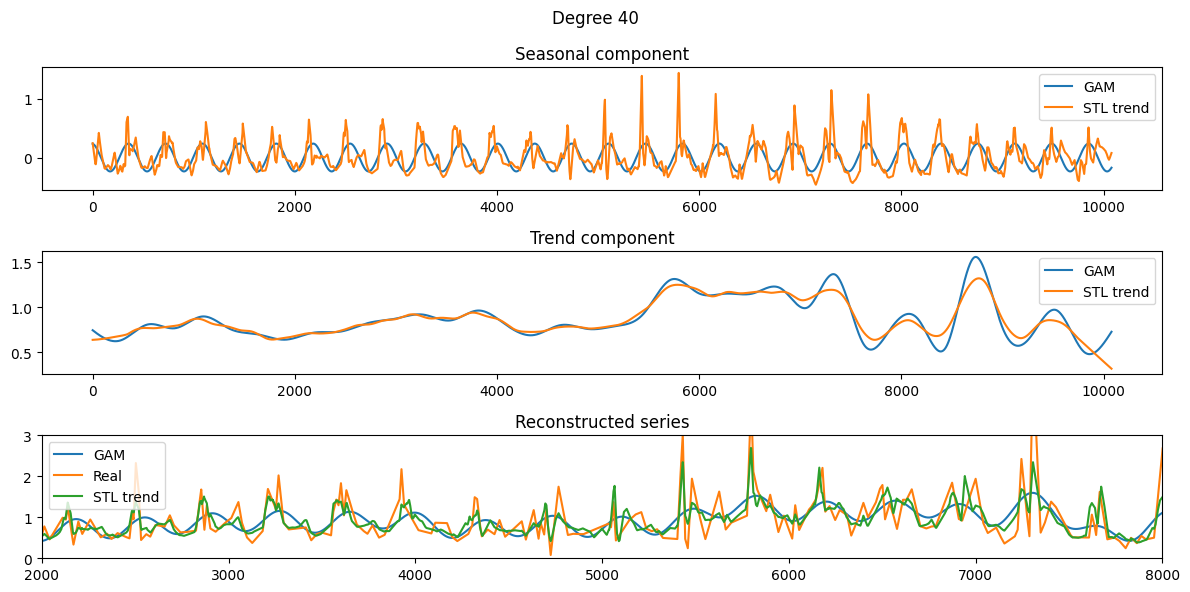

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


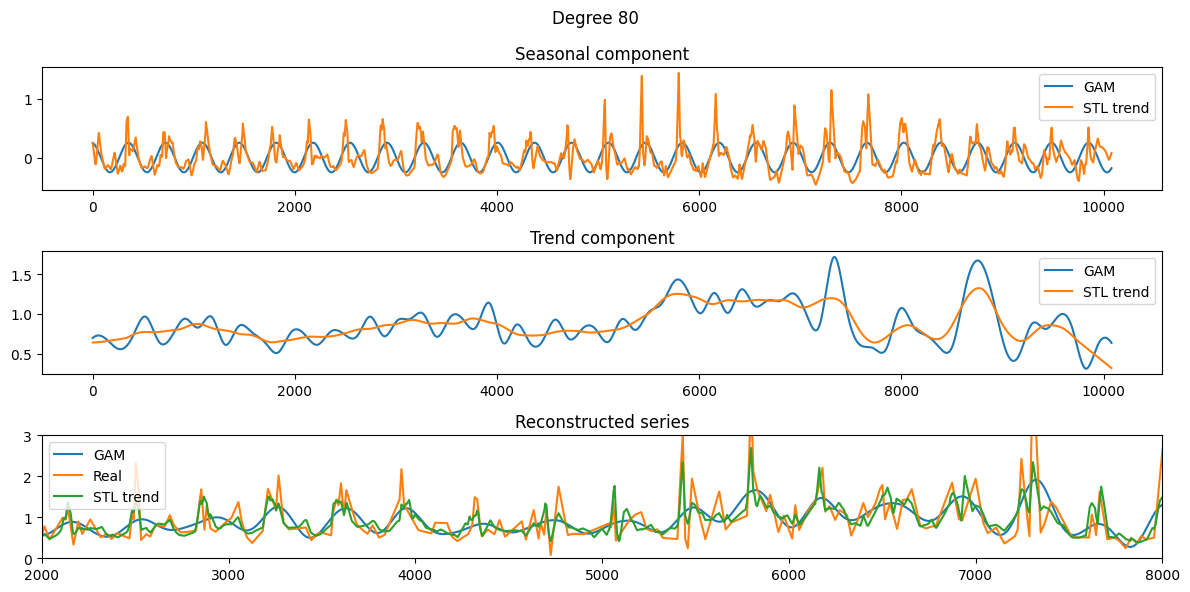

In [12]:
data_gam = data.reset_index().copy()
data_gam["time"] = pd.to_datetime(data_gam["time"])
data_gam["day_since_start"] = np.cumsum(np.ones_like(data_gam["time"], dtype=int))
data_gam["sin_doy"] = np.sin(2 * np.pi * data_gam["day_since_start"] / 365.25)
data_gam["cos_doy"] = np.cos(2 * np.pi * data_gam["day_since_start"] / 365.25)
for degree in [10, 20, 40, 80]:
    variable = "biomass"
    X = data_gam[["day_since_start", "sin_doy", "cos_doy"]].to_numpy()
    y = data_gam[variable].to_numpy()
    gam = LinearGAM(s(0, n_splines=degree) + l(1) + l(2), fit_intercept=False).fit(X, y)
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 6))
    plt.suptitle(f"Degree {degree}")
    ax1.plot(season, label="GAM")
    ax1.plot(result_stl.seasonal.to_numpy(), label="STL trend")
    ax1.legend()
    ax1.set_title("Seasonal component")

    ax2.plot(trend, label="GAM")
    ax2.plot(result_stl.trend.to_numpy(), label="STL trend")
    ax2.legend()
    ax2.set_title("Trend component")

    ax3.plot(trend + season, label="GAM")
    ax3.plot(data["biomass"].to_numpy(), label="Real")
    ax3.plot((result_stl.trend + result_stl.seasonal).to_numpy(), label="STL trend")
    ax3.legend()
    ax3.set_ylim(0, 3)
    ax3.set_xlim(2000, 8000)
    ax3.set_title("Reconstructed series")
    plt.tight_layout()
    plt.show()
